##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

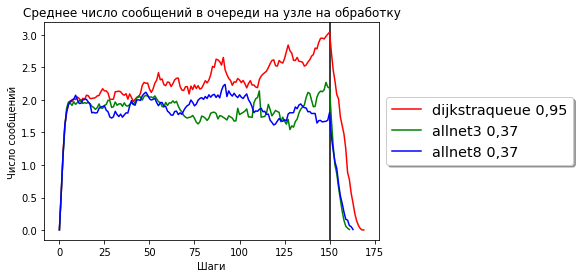

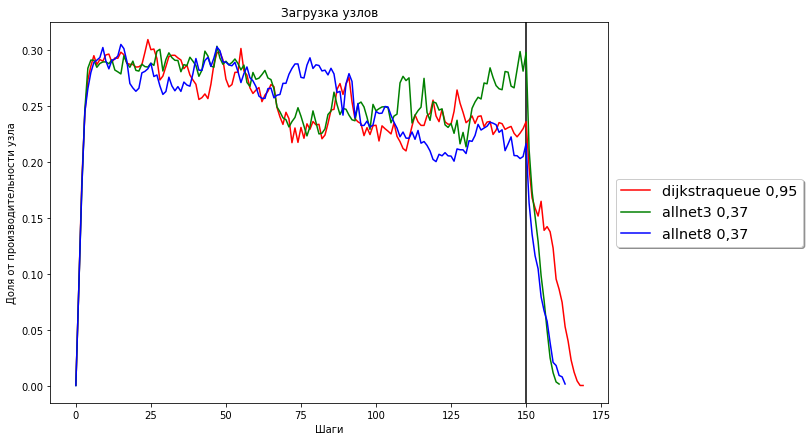

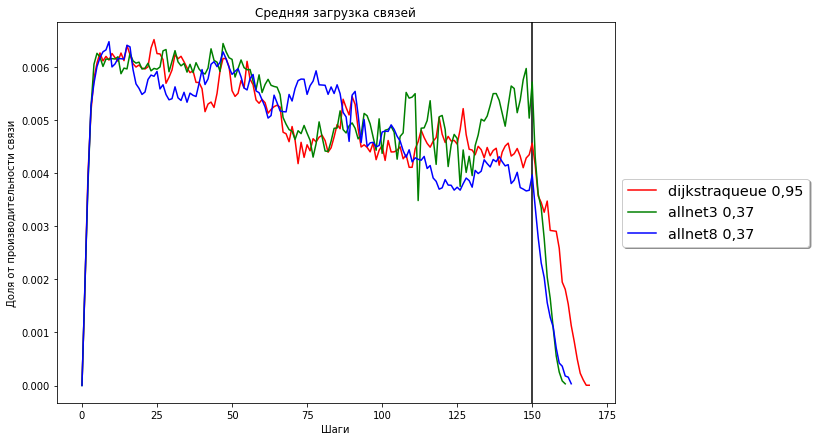

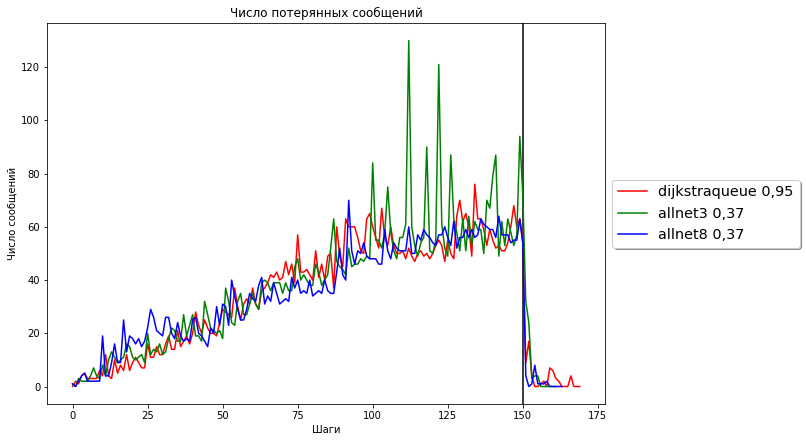

Доставлено 9375 Потеряно 37.5042% -dijkstraqueue 0,95
Доставлено 9061 Потеряно 39.5974% -allnet3 0,37
Доставлено 9495 Потеряно 36.7042% -allnet8 0,37


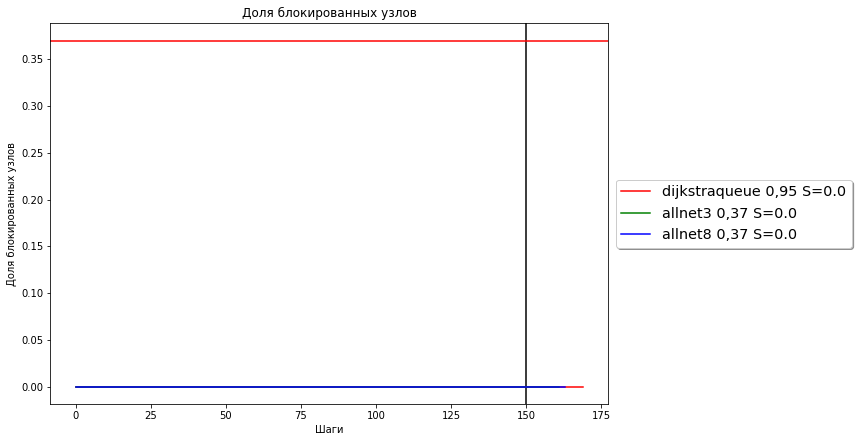

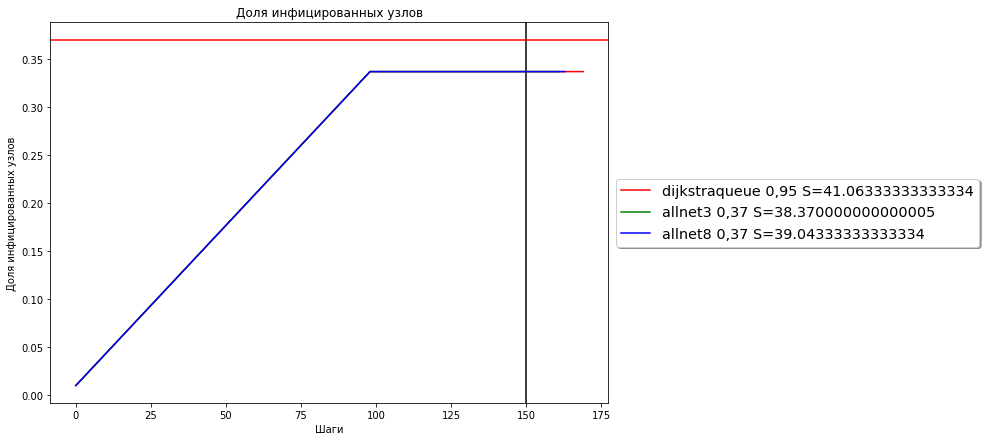

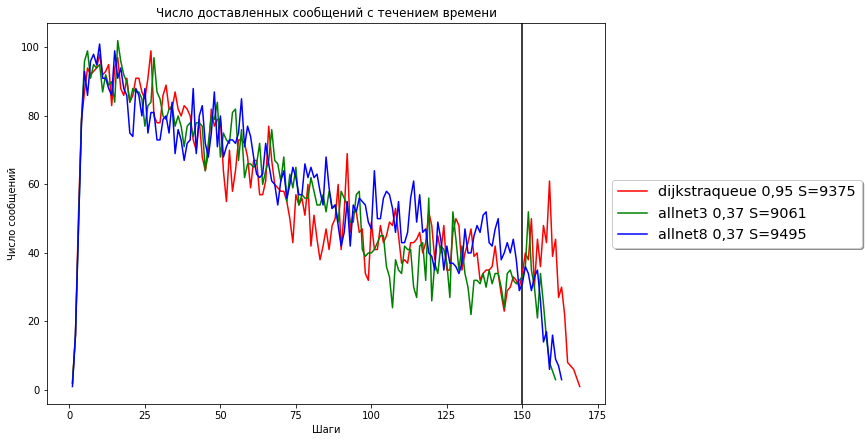

In [2]:
quantity = 100;
log_tags = [
{"tag":  "40d070fb-4d86-47b4-a348-f93f95ffa9ae", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "0e06ba5c-4a5f-44f2-a2be-5c0606f28f48", "label": "allnet3 0,37", "color": "green"},
{"tag":  "40534e5d-70e5-4356-a72e-5f2043b0fe76", "label": "allnet8 0,37", "color": "blue"},
]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

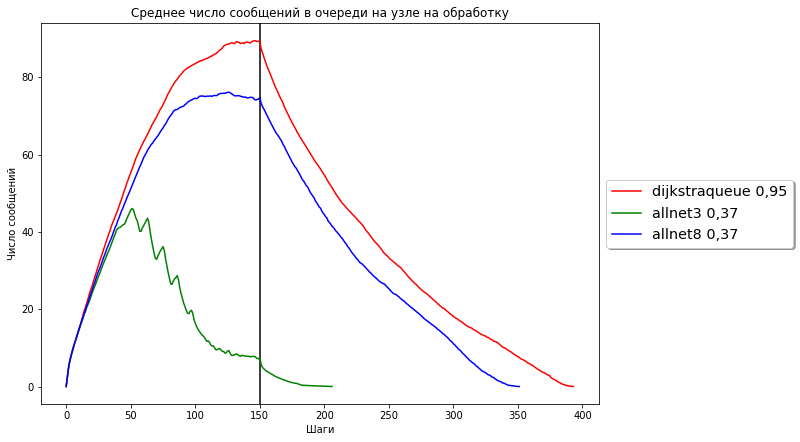

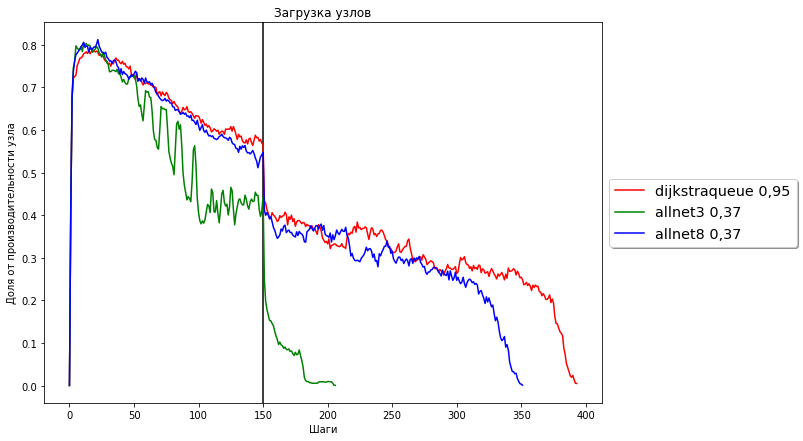

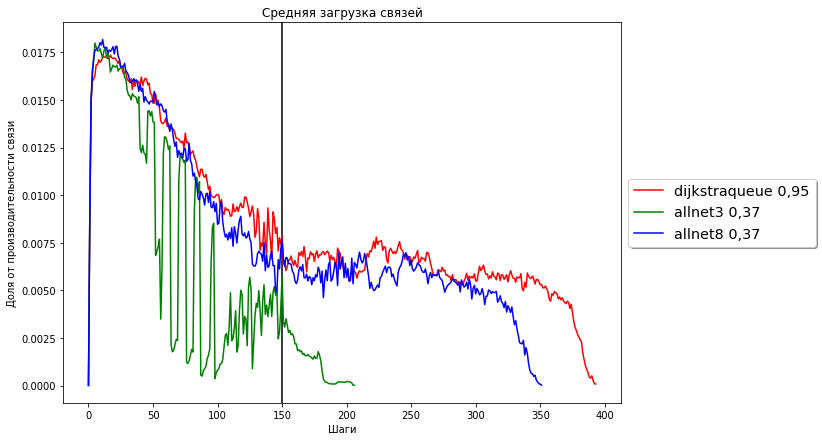

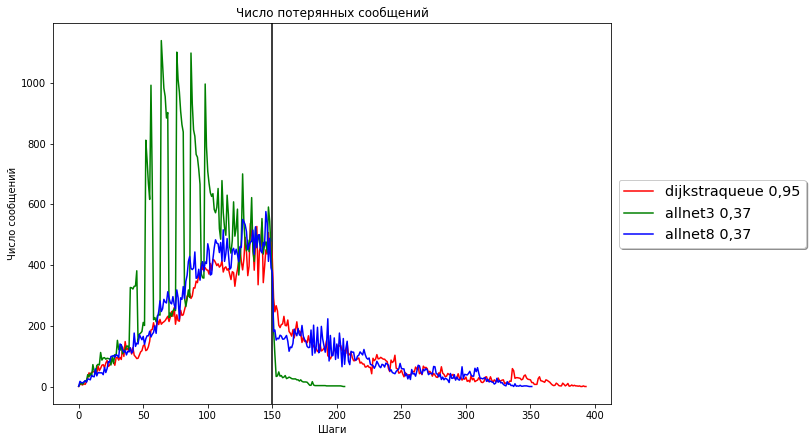

Доставлено 21540 Потеряно 71.2804% -dijkstraqueue 0,95
Доставлено 11104 Потеряно 85.1949% -allnet3 0,37
Доставлено 18281 Потеряно 75.6257% -allnet8 0,37


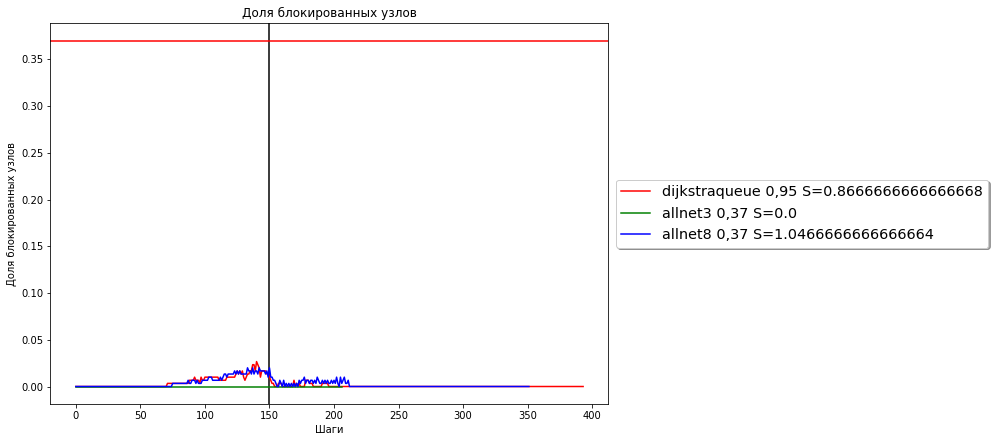

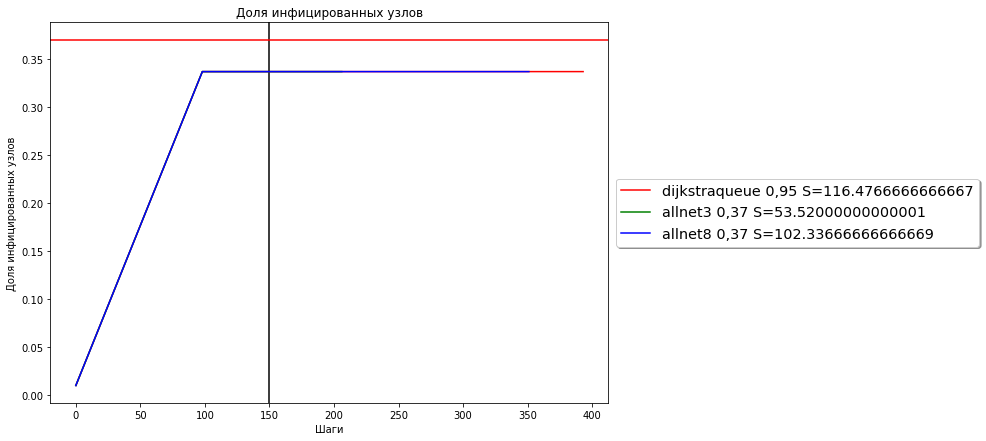

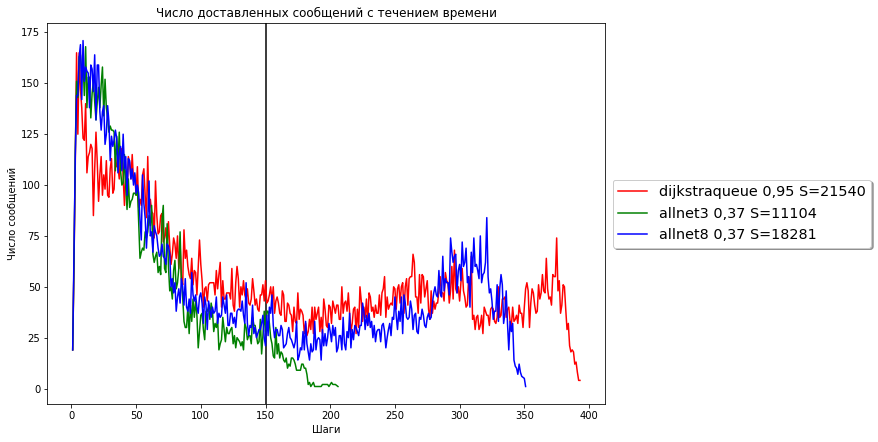

In [3]:
quantity = 500;
log_tags = [
{"tag":  "963e0244-44dd-48a1-b5cc-7f5013ccf243", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b8f4a5d4-4af0-4028-9783-61a1a1a95319", "label": "allnet3 0,37", "color": "green"},
{"tag":  "025a3a33-5221-47b4-a1a1-2d9c9f5b30a9", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

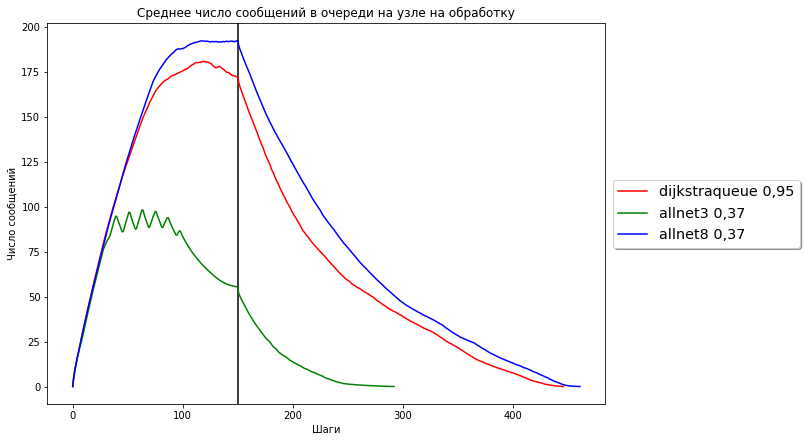

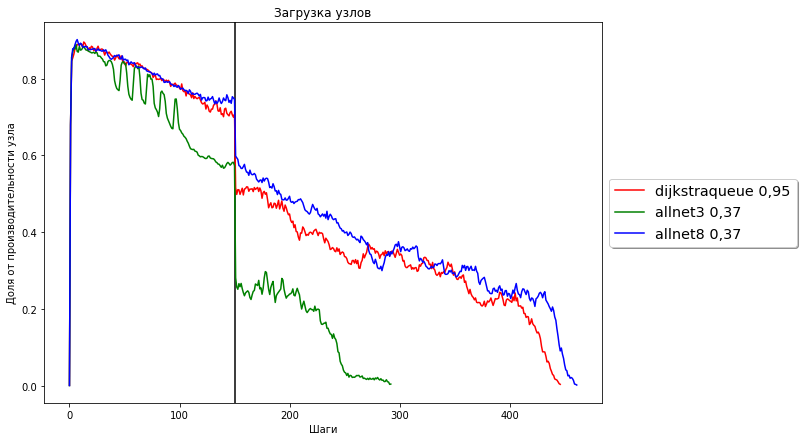

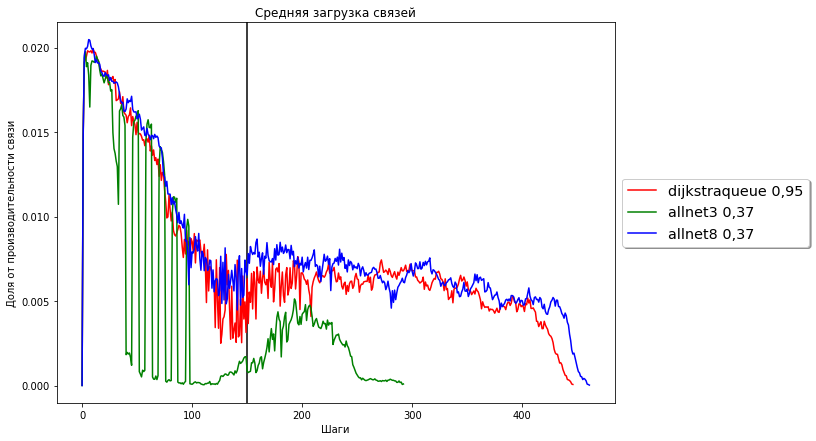

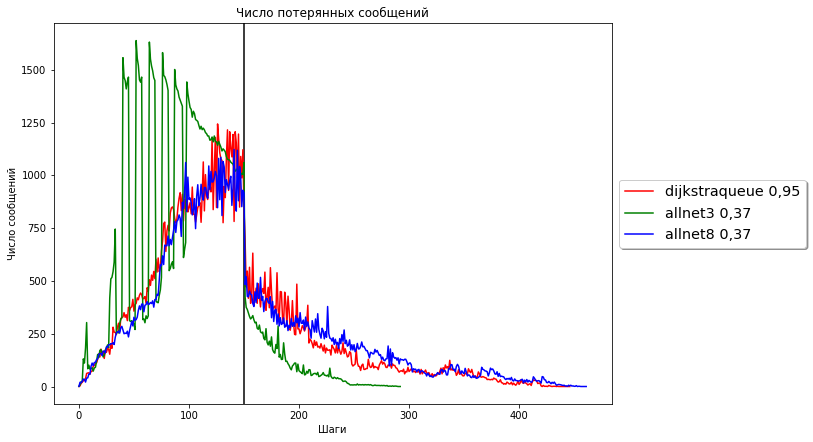

Доставлено 18256 Потеряно 87.8294% -dijkstraqueue 0,95
Доставлено 8918 Потеряно 94.0547% -allnet3 0,37
Доставлено 19567 Потеряно 86.9554% -allnet8 0,37


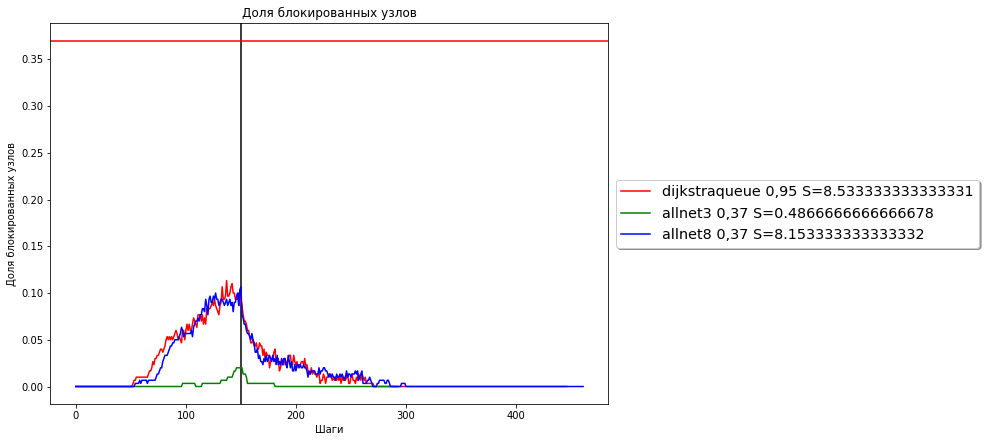

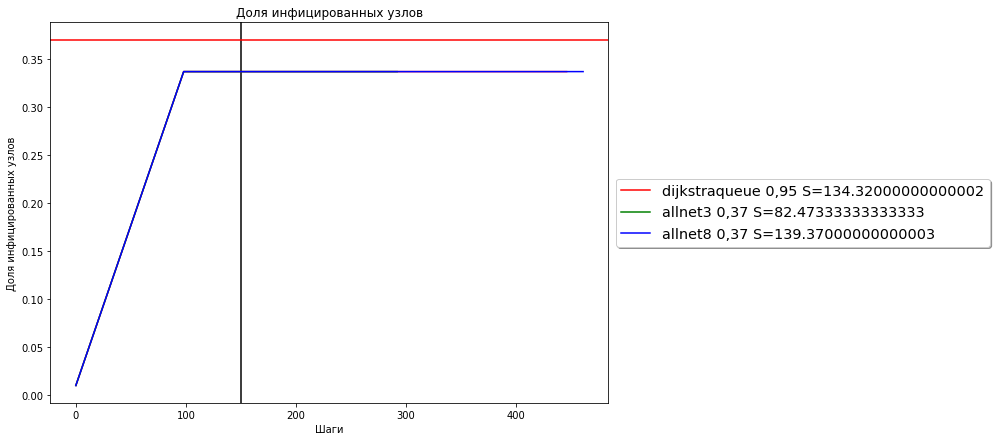

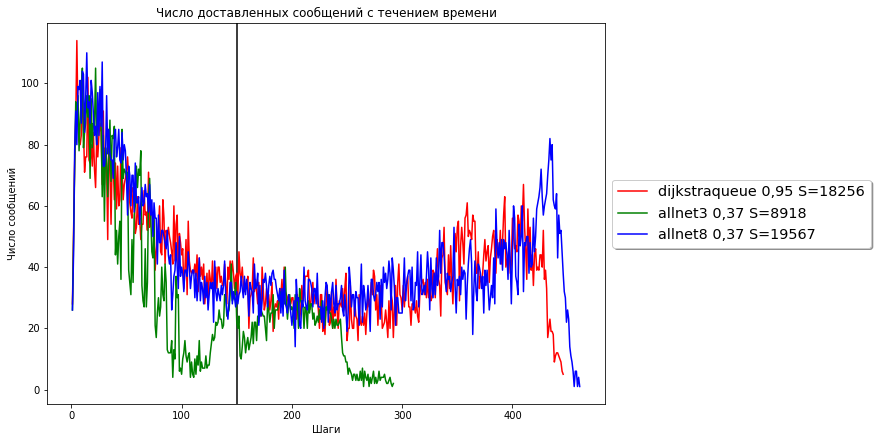

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "a3eb5b63-d885-48bb-81fe-ad4e869e9ce8", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "9543f093-e1b6-4271-a3b2-cc04cee84777", "label": "allnet3 0,37", "color": "green"},
{"tag":  "8a53abad-bdcd-46d2-bde1-5beca344425b", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

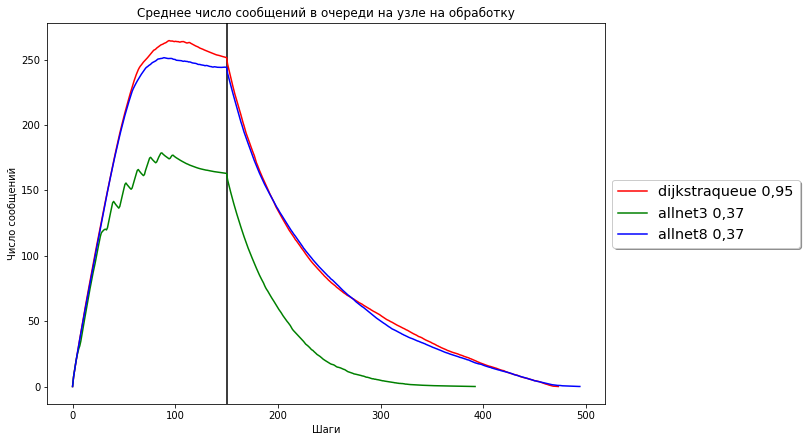

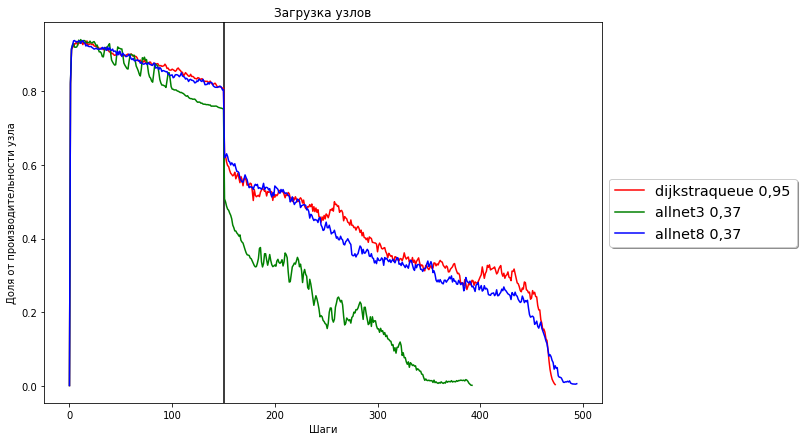

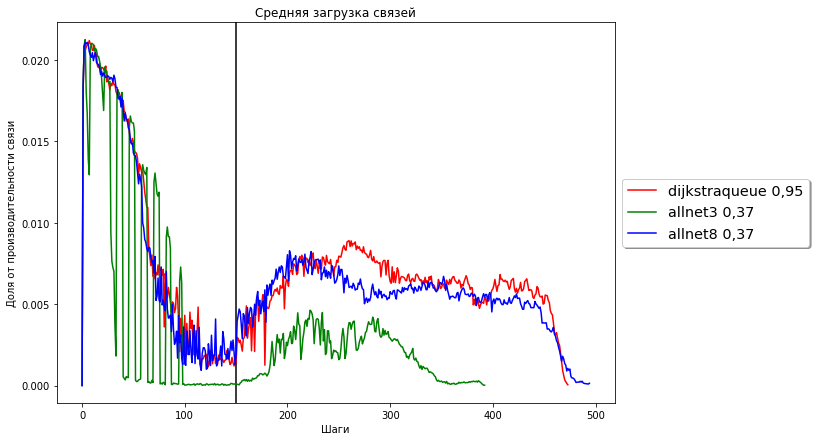

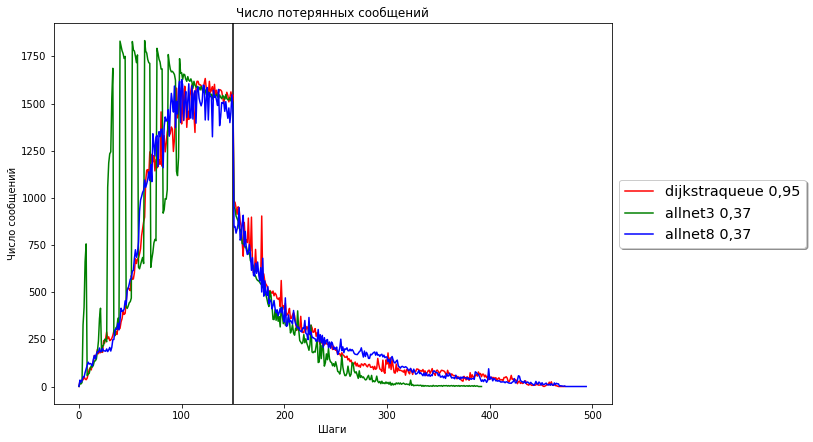

Доставлено 17569 Потеряно 92.1916% -dijkstraqueue 0,95
Доставлено 7200 Потеряно 96.8000% -allnet3 0,37
Доставлено 16644 Потеряно 92.6027% -allnet8 0,37


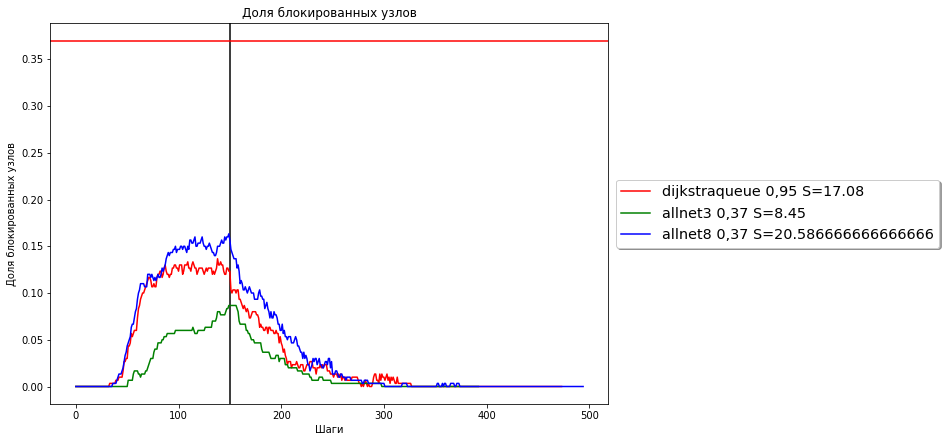

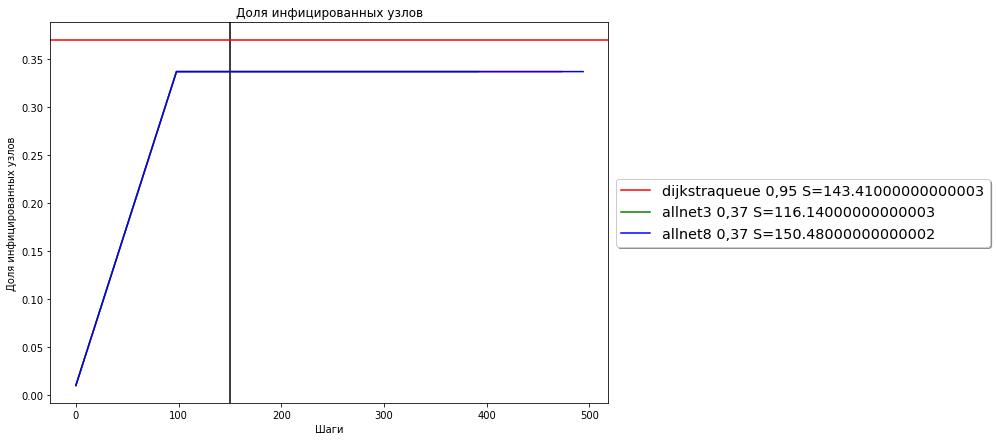

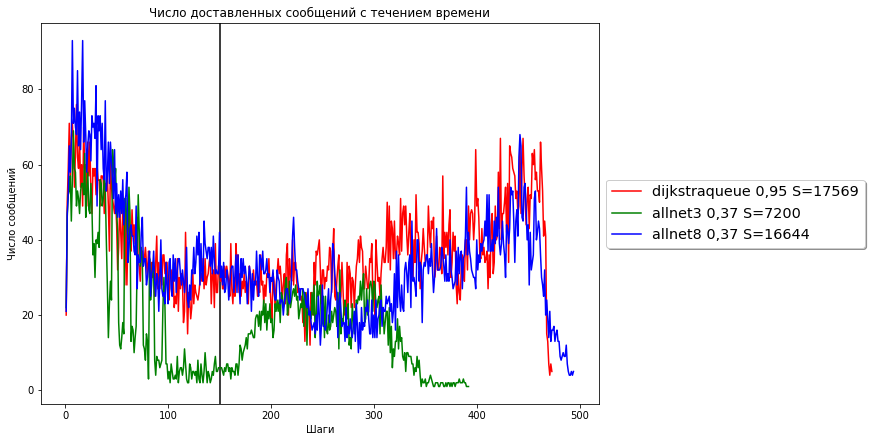

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "e124d492-fc4a-45ab-8292-dcce892eb4d9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "9620fbe9-9895-446a-b068-452fab3820ec", "label": "allnet3 0,37", "color": "green"},
{"tag":  "e476d32d-171c-4a40-baf4-575bb401ef6d", "label": "allnet8 0,37", "color": "blue"},
]

showStat()
showStatBlocked();  
showStatMessage();

Доставлено 18056 Потеряно 59.8764% -dijkstraqueue 0,95
Доставлено 11389 Потеряно 74.6917% -allnet3 0,37
Доставлено 18478 Потеряно 58.9387% -allnet8 0,37


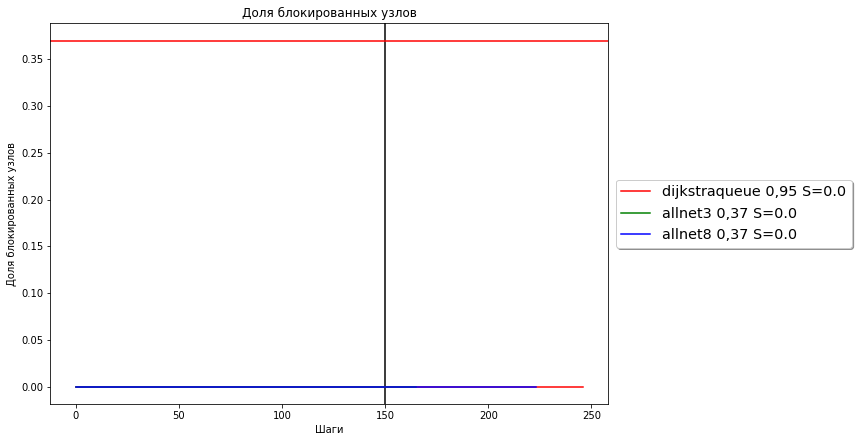

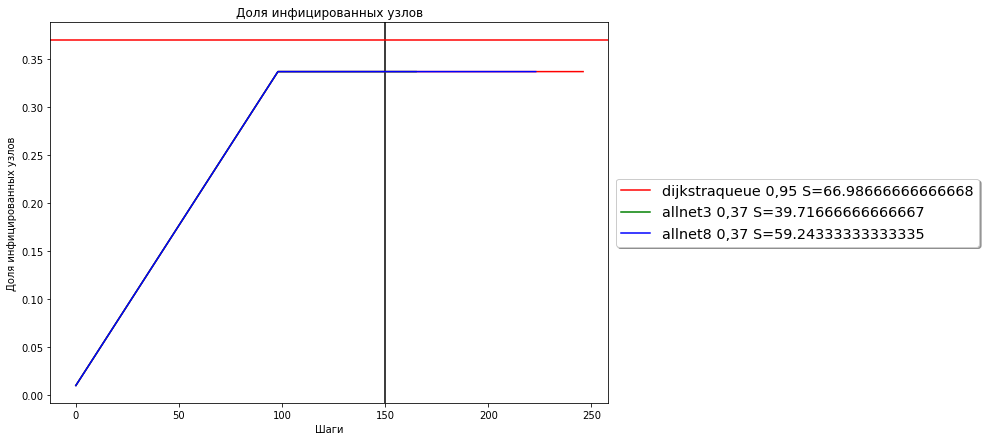

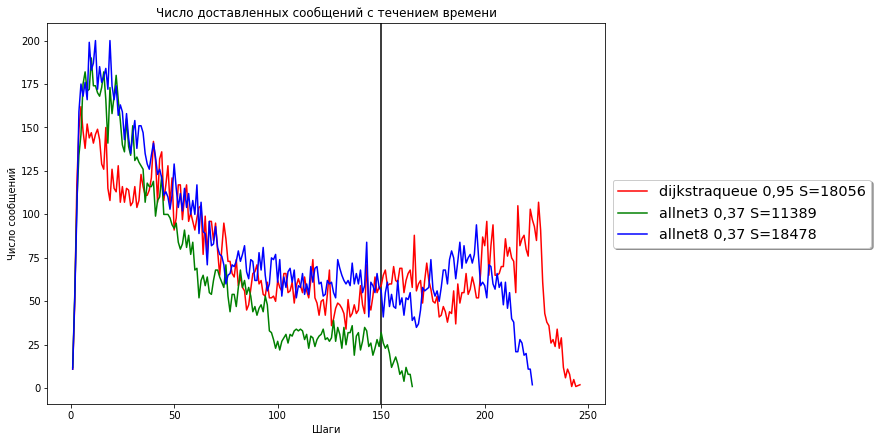

Доставлено 20052 Потеряно 80.9030% -dijkstraqueue 0,95
Доставлено 10272 Потеряно 90.2172% -allnet3 0,37
Доставлено 22247 Потеряно 78.8126% -allnet8 0,37


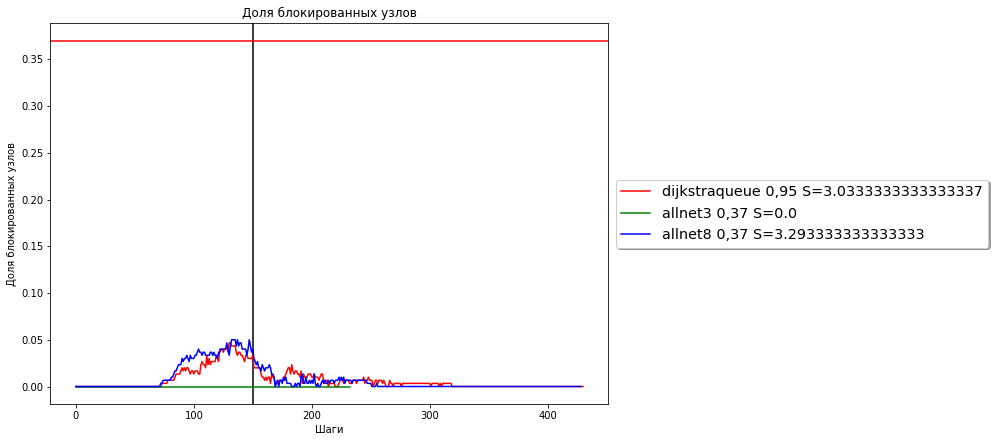

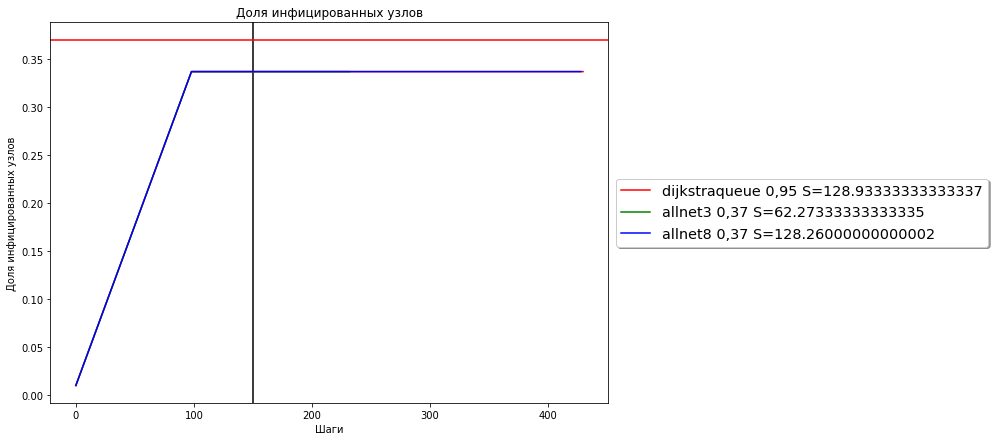

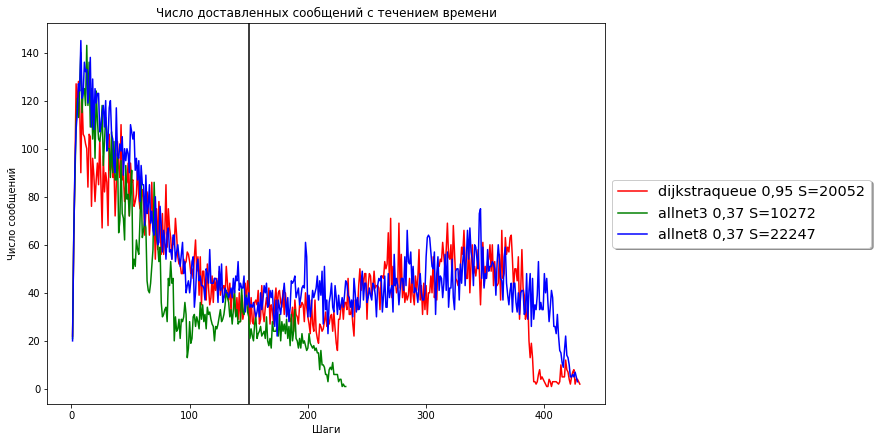

Доставлено 16842 Потеряно 87.5245% -dijkstraqueue 0,95
Доставлено 9558 Потеряно 92.9201% -allnet3 0,37
Доставлено 20011 Потеряно 85.1771% -allnet8 0,37


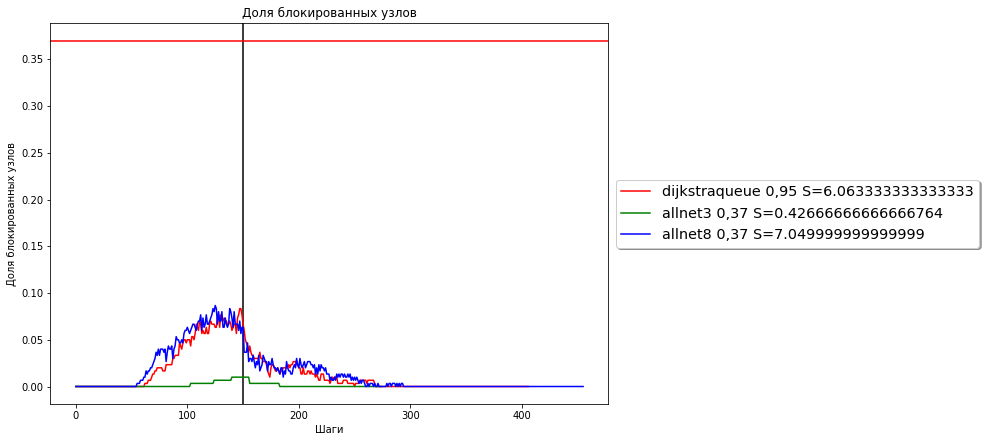

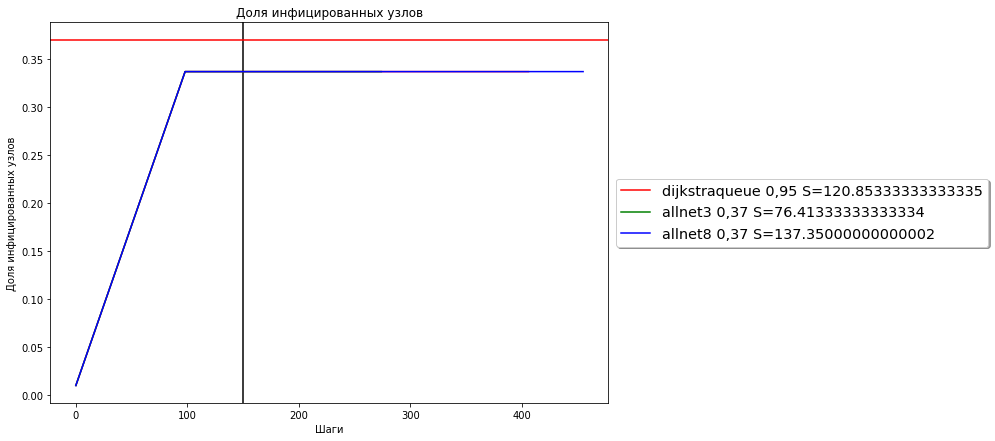

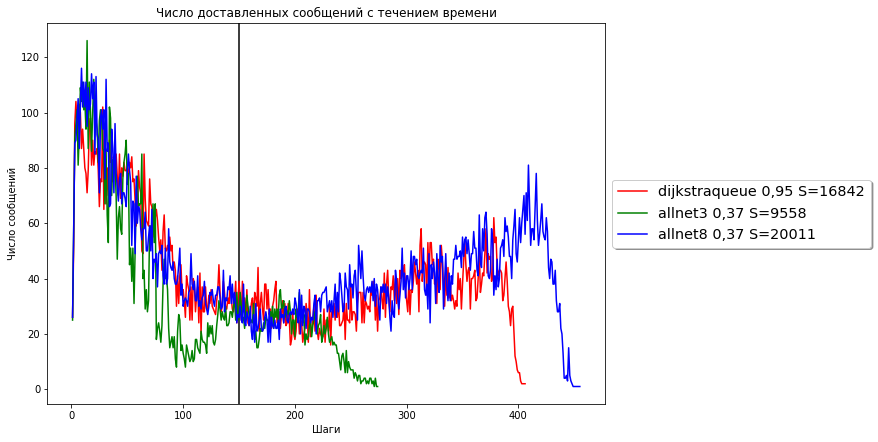

Доставлено 17992 Потеряно 90.7734% -dijkstraqueue 0,95
Доставлено 7623 Потеряно 96.0908% -allnet3 0,37
Доставлено 18971 Потеряно 90.2713% -allnet8 0,37


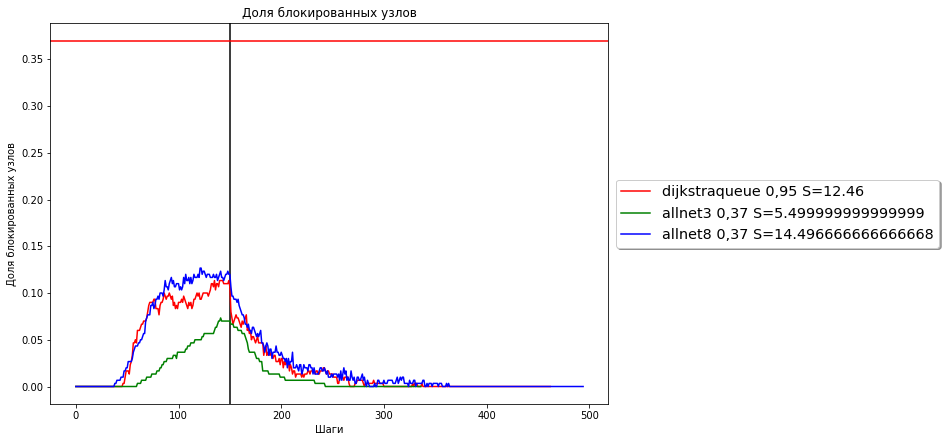

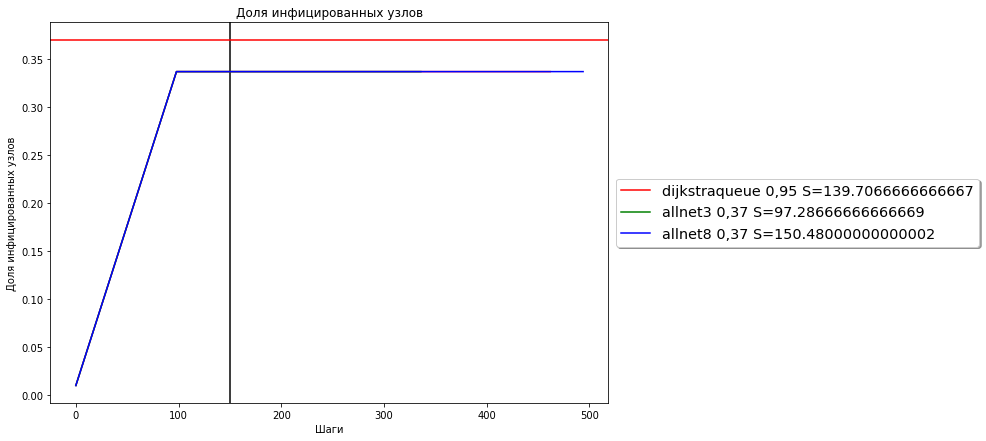

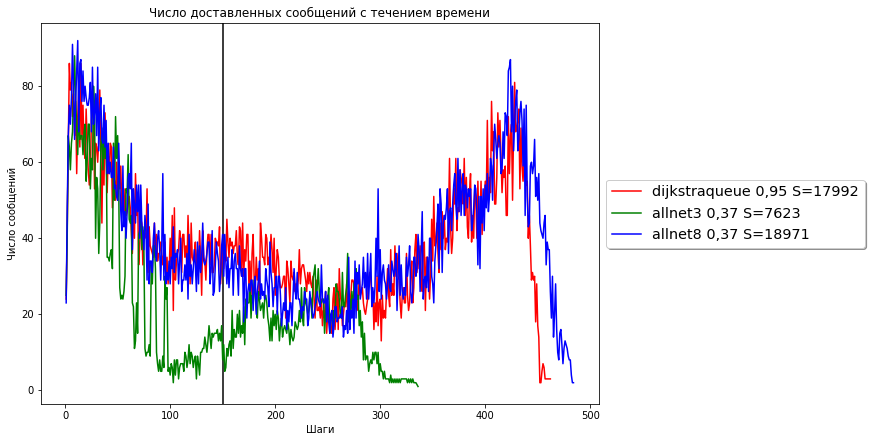

In [6]:
quantity = 300;
log_tags = [
{"tag":  "4b0118be-b104-4f39-9e93-0e3676ca787c", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "c64c252b-c3ee-4f0a-b79f-843d86c61ddc", "label": "allnet3 0,37", "color": "green"},
{"tag":  "8139f78e-161d-4ba7-9acc-985baa1a5209", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "4f6af389-e730-4f1d-9e1a-b02bb269aff7", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "a3b7b5ae-713f-4dbd-88f2-e2afafcaf7cb", "label": "allnet3 0,37", "color": "green"},
{"tag":  "e302708c-cd12-46a5-8bc6-b578ffadd90f", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "99431836-b1e4-48c7-9fda-fc6e58e85ef2", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "a1a697f4-b9dc-4f2d-a003-b6fe2d442e5b", "label": "allnet3 0,37", "color": "green"},
{"tag":  "c6abb83b-bdfc-4ca1-a008-d81f8f395efd", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "12a1117e-eb9d-408b-a000-ca742f313a75", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "8f4732a0-be4a-40aa-9272-92f9895fa3b4", "label": "allnet3 0,37", "color": "green"},
{"tag":  "d5d4b2e8-c32c-4122-8cfe-bb2d7ab81eb8", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,37  allnet8 0,37
100             5.116792      3.606093      3.732551
300            27.391747      8.937535     17.969734
500            67.059013     13.435381     55.357195
700            66.943610     17.745812     69.539147
900            63.141821     23.533929     76.515107
1000           69.890161     25.080566     79.646669
1300           70.058271     32.947641     73.717904
1500           69.608277     38.313474     67.740428


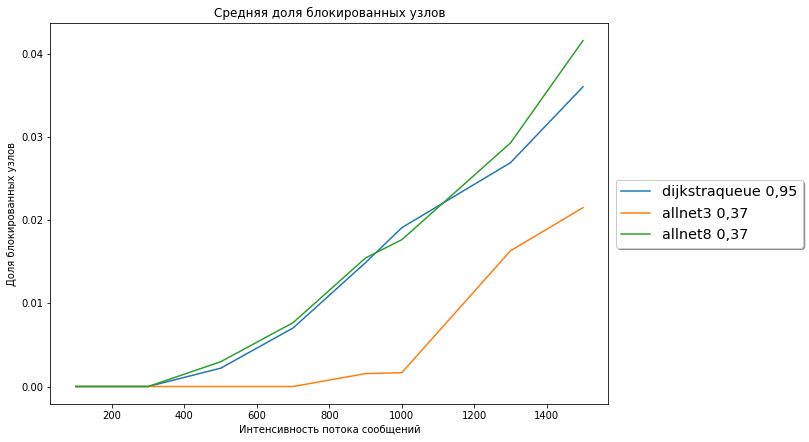

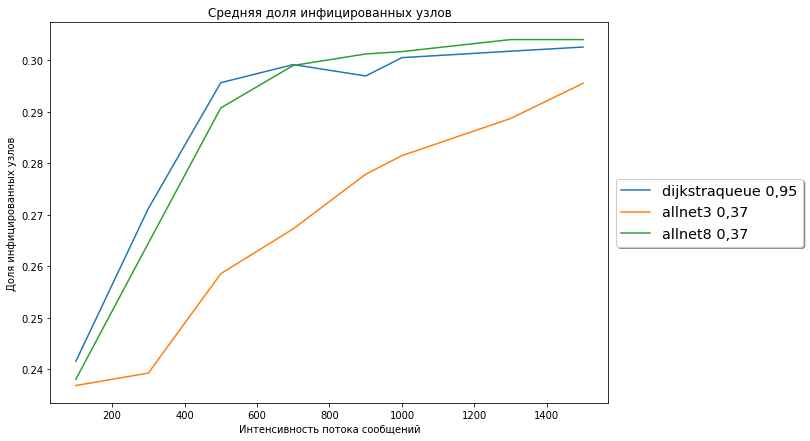

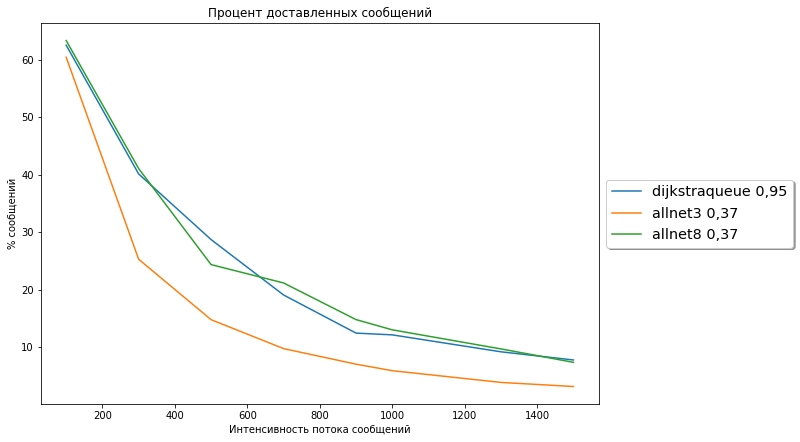

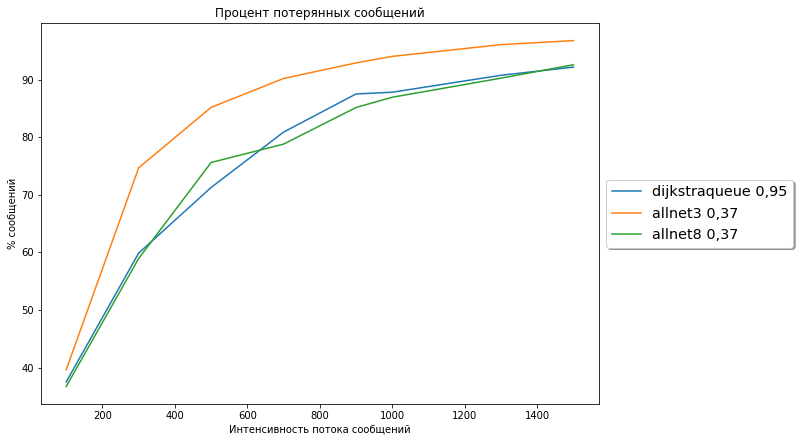

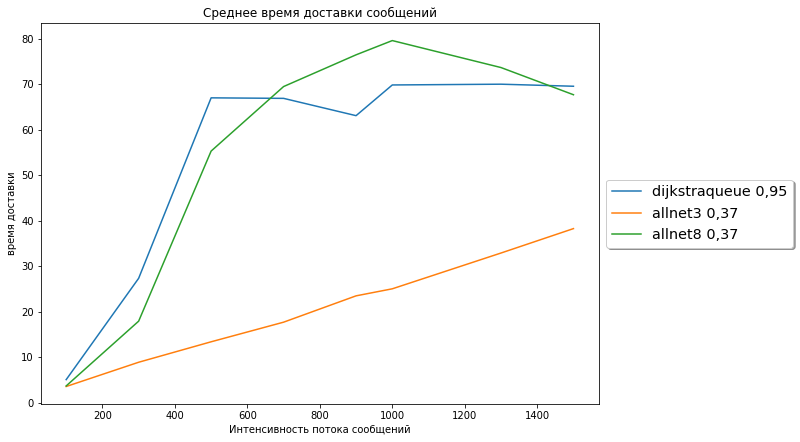

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.013271
allnet3 0,37          0.005129
allnet8 0,37          0.014329

dijkstraqueue 0,95    75.985370
allnet3 0,37          83.695837
allnet8 0,37          75.635969

dijkstraqueue 0,95    54.901212
allnet3 0,37          20.450054
allnet8 0,37          55.527342

dijkstraqueue 0,95    0.288656
allnet3 0,37          0.268185
allnet8 0,37          0.287891
